# Предсказание биологического ответа молекул

<img src="../data/molecules2.jpg" alt="molecules" width="800"/>

Необходимо предсказать биологический ответ молекул ('Activity') по их химическому составу (D1-D1776)

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [193]:
#импорт библиотек
import hyperopt as hp
import numpy as np #для матричных вычислений
import optuna
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from hyperopt import hp, fmin, tpe, Trials
from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

%matplotlib inline
plt.style.use('seaborn')

In [3]:
original_data = pd.read_csv('../data/molecules.csv')
original_data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = original_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


В таблице 3751 пример ответа молекул.

1776 признаков, характеризующих состав молекул и 1 целевая переменная Activity.

Признаки могут быть целочисленными (834) и непрерывными (942).

In [12]:
print('Пропущенные значения: ', data.isnull().sum().sum())

Пропущенные значения:  0


Пропущенных значений нет.

Данные уже закодированы и нормализованы, поэтому сразу перейдем к построению моделей.

### Оптимизация гиперпараметров модели

In [5]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

#### **Логистическая регрессия**

Зафиксируем метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [129]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42, max_iter = 50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


Сравним результаты разных типов оптимизации

**1. GridSearchCV**

In [131]:
param_grid = [
    {
        'penalty': ['l2', 'none'] , # тип регуляризации
        'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
        'C': list(np.linspace(0.01, 1, 20, dtype=float))
    },    
    {
        'penalty': ['l1', 'l2'] ,
        'solver': ['liblinear', 'saga'],
        'C': list(np.linspace(0.01, 1, 20, dtype=float))
    },
]

In [134]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    scoring='f1',
    cv=10, 
    n_jobs = -1
)  
grid_search.fit(X_train, y_train) 
print("f1_score на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}


Удалось незначительно улучшить значение метрики.

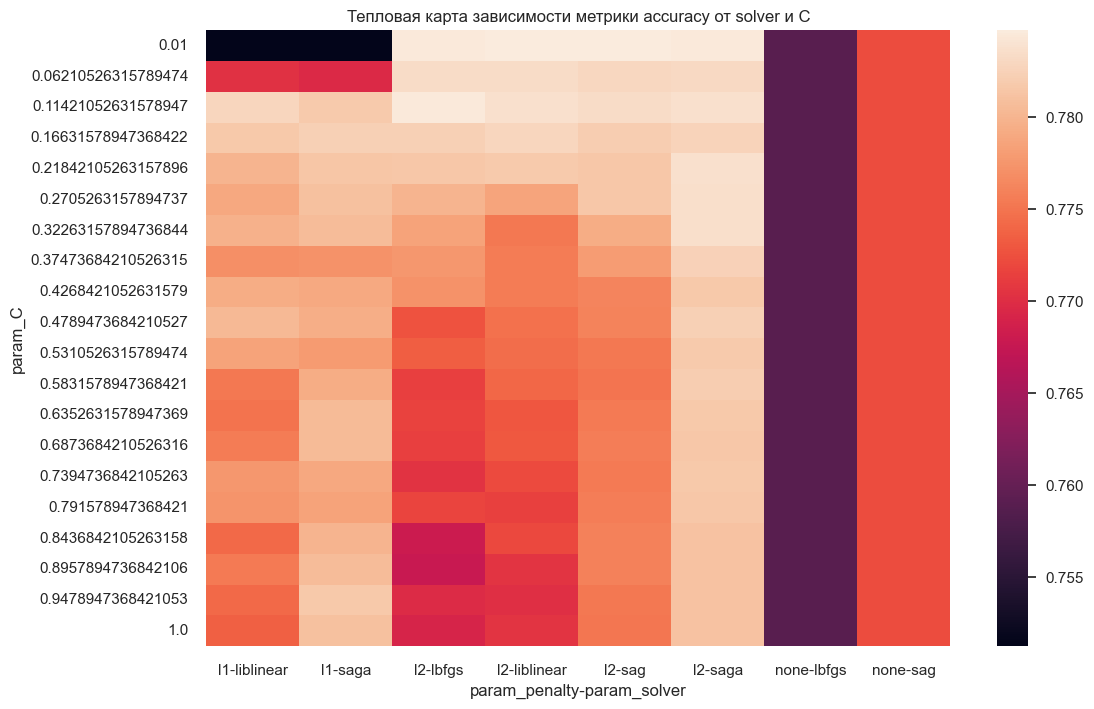

In [135]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns=['param_penalty', 'param_solver'])
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что лучшие результаты показывают модели с невысоким значением силы регуляризации и l1/l2-регуляризацией.

При дальнейшем подборе параметров можно использовать эту информацию. 

In [136]:
param_grid_2 = [
    {
        'penalty': ['l2'] , # тип регуляризации
        'solver': ['lbfgs', 'sag', 'liblinear', 'saga'], # алгоритм оптимизации
        'C': list(np.linspace(0.01, 0.5, 20, dtype=float))
    }
]

In [137]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid_2, 
    scoring='f1',
    cv=10, 
    n_jobs = -1
)  
grid_search.fit(X_train, y_train) 
print("f1_score на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'C': 0.035789473684210524, 'penalty': 'l2', 'solver': 'saga'}


Сильнее улучшить метрику не удалось. В целом, метрика увеличилась на 0.1. Но для этого пришлось подбирать параметры вручную

**2. RandomizedSearchCV**

Попробуем использовать оптимизатор RandomizedSearchCV

In [145]:
param_distributions_l1 = {
    'penalty': ['l1'] ,
    'solver': ['liblinear', 'saga'],
    'C': list(np.linspace(0.01, 0.5, 20, dtype=float))
} 
param_distributions_l2 = {
    'penalty': ['l2'] , # тип регуляризации
    'solver': ['lbfgs', 'sag', 'liblinear', 'saga'], # алгоритм оптимизации
    'C': list(np.linspace(0.01, 0.5, 20, dtype=float))
} 

In [146]:
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions_l1, 
    cv=10, 
    scoring='f1',
    n_iter = 20, 
    # n_jobs = -1
)  
random_search.fit(X_train, y_train) 
print("f1_score на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.21842105263157896}


In [148]:
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions_l2, 
    cv=10, 
    scoring='f1',
    n_iter = 20, 
    # n_jobs = -1
)  
random_search.fit(X_train, y_train) 
print("f1_score на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.32263157894736844}


Оптимизатор отработал быстрее. Но метрика f1-score не улучшилась

**3. Hyperopt**

In [178]:
# зафксируем random_state
random_state = 42
def hyperopt_lr(params, cv=10, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {
        'penalty': params['penalty'], 
        'solver': params['solver'], 
        'C': params['C'],
        # 'max_iter': int(params['max_iter'])
    }
    if params['C']==0:
        return 0
    # зададим пространство поиска гиперпараметров
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, max_iter=50, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    
    # if cross_validate:
    #     score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # else:
    #     score = metrics.f1_score(y, model.predict(X))
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

Нам потребуется несколько пространств гиперпараметров

In [188]:
penalty_l1 = ['l1']
solver_l1 = ['liblinear', 'saga']
space_l1 = {
    'penalty': hp.choice('penalty', penalty_l1), # тип регуляризации
    'solver': hp.choice('solver', solver_l1), # алгоритм оптимизации
    'C': hp.quniform('C', 0.01, 0.5, 0.01),
    # 'max_iter': hp.quniform('max_iter', 10, 50, 5)
}

penalty_l2 = ['l2']
solver_l2 = ['lbfgs', 'sag', 'liblinear', 'saga']
space_l2 = {
    'penalty': hp.choice('penalty', penalty_l2), # тип регуляризации
    'solver': hp.choice('solver', solver_l2), # алгоритм оптимизации
    'C': hp.quniform('C', 0.01, 0.5, 0.01),
    # 'max_iter': hp.quniform('max_iter', 10, 50, 5)
}

In [181]:
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(
    hyperopt_lr, # наша функция 
    space=space_l1, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=penalty_l1[best['penalty']],
    solver=solver_l1[best['solver']],
    C=best['C'],
    # max_iter=int(best['max_iter'])
    max_iter=50
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [08:24<00:00, 25.20s/trial, best loss: -0.7814251316350409]
Наилучшие значения гиперпараметров {'C': 0.25, 'penalty': 0, 'solver': 1}
f1_score на тестовом наборе: 0.78


In [183]:
best=fmin(
    hyperopt_lr, # наша функция 
    space=space_l1, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=30, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=penalty_l1[best['penalty']],
    solver=solver_l1[best['solver']],
    C=best['C'],
    # max_iter=int(best['max_iter'])
    max_iter=50
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

40trial [00:00, ?trial/s, best loss=?]
Наилучшие значения гиперпараметров {'C': 0.16, 'penalty': 0, 'solver': 1}
f1_score на тестовом наборе: 0.79


Улучшить метрику с помощью первого набора параметров не удалось

In [187]:
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(
    hyperopt_lr, # наша функция 
    space=space_l2, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    max_iter=50,
    random_state=random_state, 
    penalty=penalty_l2[best['penalty']],
    solver=solver_l2[best['solver']],
    C=best['C']
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [05:02<00:00, 15.12s/trial, best loss: -0.7855646326818487]
Наилучшие значения гиперпараметров {'C': 0.03, 'penalty': 0, 'solver': 0}
f1_score на тестовом наборе: 0.79


In [189]:
best=fmin(hyperopt_lr, # наша функция 
          space=space_l2, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=30, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    max_iter=50,
    random_state=random_state, 
    penalty=penalty_l2[best['penalty']],
    solver=solver_l2[best['solver']],
    C=best['C']
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 30/30 [01:42<00:00, 10.24s/trial, best loss: -0.7858668594512256]
Наилучшие значения гиперпараметров {'C': 0.03, 'penalty': 0, 'solver': 2}
f1_score на тестовом наборе: 0.79


Метрика осталась прежней.

**4. Optuna**

In [196]:
def optuna_lr_l1(trial):
  # задаем пространства поиска гиперпараметров 
  params = {
    'penalty': trial.suggest_categorical('penalty', ['l1']), # тип регуляризации
    'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']), # алгоритм оптимизации
    'C': trial.suggest_float('C', 0.01, 0.5, step=0.01)
  }

  # создаем модель
  model = linear_model.LogisticRegression(**params, max_iter=50, random_state=random_state)
  
  # обучаем модель
  model.fit(X_train, y_train)
  # score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X_train, y_train, cv=10, scoring="f1", n_jobs=-1).mean()

  return score

In [202]:
def optuna_lr_l2(trial):
  # задаем пространства поиска гиперпараметров 
  params = {
    'penalty': trial.suggest_categorical('penalty', ['l2']), # тип регуляризации
    'solver': trial.suggest_categorical('solver', ['lbfgs', 'sag', 'liblinear', 'saga']), # алгоритм оптимизации
    'C': trial.suggest_float('C', 0.01, 0.5, step=0.01)
  }

  # создаем модель
  model = linear_model.LogisticRegression(**params, max_iter=50, random_state=random_state)
  
  # обучаем модель
  model.fit(X_train, y_train)
  # score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X_train, y_train, cv=10, scoring="f1", n_jobs=-1).mean()

  return score

In [197]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr_l1, n_trials=20)

[I 2023-05-02 11:22:43,119] A new study created in memory with name: LogisticRegression
[I 2023-05-02 11:22:51,705] Trial 0 finished with value: 0.7800849302336168 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.34}. Best is trial 0 with value: 0.7800849302336168.
[I 2023-05-02 11:23:32,629] Trial 1 finished with value: 0.7819323965217131 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.22}. Best is trial 1 with value: 0.7819323965217131.
[I 2023-05-02 11:24:18,800] Trial 2 finished with value: 0.7778587106357864 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.37}. Best is trial 1 with value: 0.7819323965217131.
[I 2023-05-02 11:24:58,562] Trial 3 finished with value: 0.7734015745029797 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.08}. Best is trial 1 with value: 0.7819323965217131.
[I 2023-05-02 11:25:04,774] Trial 4 finished with value: 0.779325744030897 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.5}. Best is tria

CPU times: total: 1min 45s
Wall time: 10min 12s


In [200]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.14}
f1_score на тестовом наборе: 0.79


In [203]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr_l2, n_trials=20)

[I 2023-05-02 11:40:35,019] A new study created in memory with name: LogisticRegression
[I 2023-05-02 11:40:45,794] Trial 0 finished with value: 0.7816276140148152 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.21000000000000002}. Best is trial 0 with value: 0.7816276140148152.
[I 2023-05-02 11:41:16,026] Trial 1 finished with value: 0.7832474532886933 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.33}. Best is trial 1 with value: 0.7832474532886933.
[I 2023-05-02 11:41:19,650] Trial 2 finished with value: 0.7852531080473143 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.06999999999999999}. Best is trial 2 with value: 0.7852531080473143.
[I 2023-05-02 11:41:46,924] Trial 3 finished with value: 0.7816571323388104 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.15000000000000002}. Best is trial 2 with value: 0.7852531080473143.
[I 2023-05-02 11:42:14,232] Trial 4 finished with value: 0.7812590380683182 and parameters: {'penalty': 'l2', 

CPU times: total: 42.4 s
Wall time: 3min 58s


In [204]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.06999999999999999}
f1_score на тестовом наборе: 0.80


Удалось улучшить метрику на 0.1. Т.о. параметры логистической регрессии по умолчанию являются одними из самых оптимальных, ни один из способов оптимизации не позволил существенно улучшить метрику.

#### **Случайный лес**

Зафиксируем метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [209]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=random_state)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Test: 0.81


Случайный лес сразу показывает лучшие результаты, чем логистическая регрессия.

Сравним результаты разных типов оптимизации

**1. GridSearchCV**

In [234]:
param_grid = {
    'n_estimators': list(range(80, 200, 10)),
    'min_samples_leaf': [5],
    'max_depth': list(np.linspace(10, 30, 5, dtype=int))
}
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=param_grid, 
    cv=10, 
    scoring='f1',
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 7.84 s
Wall time: 15min 38s
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 110}


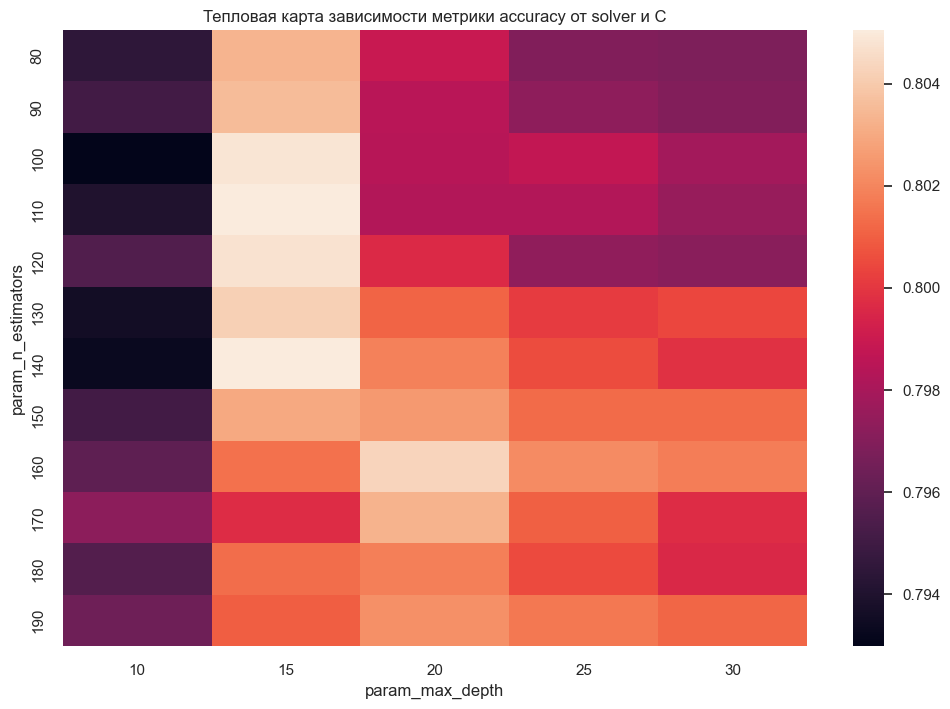

In [235]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_forest.cv_results_),
                        values='mean_test_score', index=['param_n_estimators'],
                        columns=['param_max_depth'])
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Удалось улучшить модель с помощью ручной сетки параметров.

Дальнейшее уточнение параметров для GridSearchCV не принес лучших результатов

**2. RandomizedSearchCV**

In [245]:
param_distributions = {
    'n_estimators': list(np.linspace(100, 160, 13, dtype=int)),
    'min_samples_leaf': [5],
    'max_depth': list(np.linspace(10, 25, 5, dtype=int))
}
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_distributions=param_distributions, 
    cv=10,
    scoring='f1',
    n_iter = 30, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 5.06 s
Wall time: 6min 4s
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 125, 'min_samples_leaf': 5, 'max_depth': 13}


**3. Hyperopt**

In [247]:
# зададим пространство поиска гиперпараметров
space = {
       'n_estimators': hp.quniform('n_estimators', 110, 160, 1),
       'max_depth' : hp.quniform('max_depth', 11, 24, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 6, 1)
}

In [248]:
def hyperopt_rf(params, cv=10, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']), 
        'min_samples_leaf': int(params['min_samples_leaf'])
    }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [251]:
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(
    hyperopt_rf, # наша функция 
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [06:15<00:00, 18.77s/trial, best loss: -0.807903170418055] 
Наилучшие значения гиперпараметров {'max_depth': 16.0, 'min_samples_leaf': 5.0, 'n_estimators': 126.0}
f1_score на тестовом наборе: 0.82


In [252]:
best=fmin(
    hyperopt_rf, # наша функция 
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=30, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 30/30 [02:53<00:00, 17.38s/trial, best loss: -0.807903170418055]
Наилучшие значения гиперпараметров {'max_depth': 16.0, 'min_samples_leaf': 5.0, 'n_estimators': 126.0}
f1_score на тестовом наборе: 0.82


Оптимизатор hyperport с заданным количеством итераций улучшил метрику хуже, чем GridSearchCV 

**4. Optuna**

In [253]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 110, 160, 1)
  max_depth = trial.suggest_int('max_depth', 11, 24, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 6, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [254]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-05-02 21:20:01,296] A new study created in memory with name: RandomForestClassifier
[I 2023-05-02 21:20:05,606] Trial 0 finished with value: 0.9428658722884204 and parameters: {'n_estimators': 154, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9428658722884204.
[I 2023-05-02 21:20:08,863] Trial 1 finished with value: 0.9332516840171464 and parameters: {'n_estimators': 132, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9428658722884204.
[I 2023-05-02 21:20:11,892] Trial 2 finished with value: 0.9446652399877714 and parameters: {'n_estimators': 118, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9446652399877714.
[I 2023-05-02 21:20:15,009] Trial 3 finished with value: 0.9443425076452601 and parameters: {'n_estimators': 121, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9446652399877714.
[I 2023-05-02 21:20:19,157] Trial 4 finished with value: 0.9438339438339438 and parameters: {'n_

CPU times: total: 1min 9s
Wall time: 1min 14s


In [255]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 142, 'max_depth': 22, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.95


In [256]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


In [257]:
%%time
# можем продолжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2023-05-02 21:22:02,416] Trial 20 finished with value: 0.9357011635027557 and parameters: {'n_estimators': 154, 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.9455990220048901.
[I 2023-05-02 21:22:06,753] Trial 21 finished with value: 0.9459541984732824 and parameters: {'n_estimators': 159, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.9459541984732824.
[I 2023-05-02 21:22:11,044] Trial 22 finished with value: 0.9468215158924205 and parameters: {'n_estimators': 160, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 22 with value: 0.9468215158924205.
[I 2023-05-02 21:22:15,199] Trial 23 finished with value: 0.947143293614421 and parameters: {'n_estimators': 159, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 23 with value: 0.947143293614421.
[I 2023-05-02 21:22:19,350] Trial 24 finished with value: 0.9454766981419434 and parameters: {'n_estimators': 159, 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 23 with valu

CPU times: total: 38.7 s
Wall time: 41.1 s


In [258]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 159, 'max_depth': 22, 'min_samples_leaf': 5}
f1_score на тестовом наборе: 0.82


Подведем итоги.

|Модель | Оптимизатор | f1 на тестовой выборке
|--|--|--
|Логистическая регрессия | Без оптимизатора | 0.79
| | GridSearchCV | 0.80
| | RandomizedSearchCV | 0.78
| | Hyperopt | 0.79
| | Optuna | 0.80
| Случайный лес | Без оптимизатора | 0.79
| | GridSearchCV | **0.83**
| | RandomizedSearchCV | 0.82
| | Hyperopt | 0.82
| | Optuna | 0.82

Случайный лес показал лучшие результаты. В данном случае лучше сего подобрал параметры оптимизатор GridSearchCV.

Но нам, скорее всего, просто повезло сразу угадать оптимальную сетку параметров для GridSearchCV. 

Этот оптимизатор работает медленнее всего. А также не так гибок, как другие оптимизаторы. В других случаях он мог не показать лучшие результаты.